# $\ell_p + \ell_2$

Let $0<p<1$, $\chi>0$, $\mu>0$. For $t\ge 0$

$$
\rho_{p+2}(t)=\chi\,t^{p}+\frac{\mu}{2}\,t^{2}
$$

For $\theta\in\mathbb R^p$

$$
g(\theta)=\sum_{i=1}^p \rho_{p+2}\bigl(|\theta_i|\bigr)
$$

$\rho_{p+2}$ is even and coercive thanks to the quadratic term. Near $0$ the term $\chi t^p$ dominates so the function is steep as $t\to\infty$ the growth is quadratic

In [1]:
using LinearAlgebra, Statistics, Random, Printf, Plots, LaTeXStrings

In [2]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

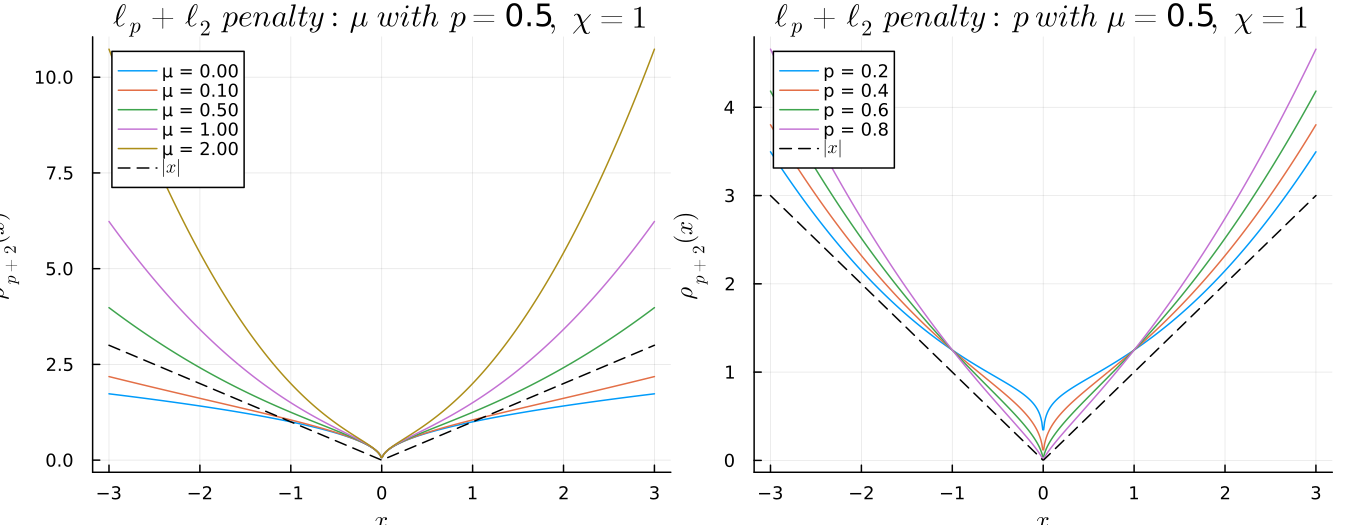

In [3]:
gr()

# ℓ_p + ℓ_2 penalty:  ρ_{p+2}(x) = χ*|x|^p + (μ/2)*x^2
rho_p2(χ, μ, p, x) = χ*abs(x)^p + 0.5*μ*x^2

# fixed χ as requested
χ_fix = 1.0

# grids
xs_big  = range(-3.0,  3.0;  length=600)
xs_zoom = range(-0.05, 0.05; length=600)

# ----- 1) Vary μ with fixed p -----
μs     = [0.0, 0.1, 0.5, 1.0, 2.0]   # μ>=0 allowed  μ=0 gives pure ℓ_p
p_fix  = 0.5

pltμ = plot(
    title  = L"\ell_p+\ell_2\ penalty: \mu\ with\ p=" * "$(p_fix)" * L",\ \chi=1",
    xlabel = L"x", ylabel = L"\rho_{p+2}(x)",
    legend = :topleft,  dpi = 150, lw=2
)
for μ in μs
    plot!(pltμ, xs_big, x -> rho_p2(χ_fix, μ, p_fix, x),
          label = @sprintf("μ = %.2f", μ))
end
# optional reference |x|
plot!(pltμ, xs_big, abs; linestyle = :dash, color = :black, label = L"|x|")

# ----- 2) Vary p with fixed μ -----
ps     = [0.2, 0.4, 0.6, 0.8]
μ_fix  = 0.5

pltp = plot(
    title  = L"\ell_p+\ell_2\ penalty: p\ with\ \mu=" * "$(μ_fix)" * L",\ \chi=1",
    xlabel = L"x", ylabel = L"\rho_{p+2}(x)",
    legend = :topleft,  dpi = 150, lw=2
)
for p in ps
    plot!(pltp, xs_big, x -> rho_p2(χ_fix, μ_fix, p, x),
          label = @sprintf("p = %.1f", p))
end
plot!(pltp, xs_big, abs; linestyle = :dash, color = :black, label = L"|x|")

# ----- Compose -----
plot(pltμ, pltp; layout = (1, 2), size = (900, 350))

In [4]:
# G(u) = u + γλμ u + γλχ p u^(p-1)
G(u, γ, λ, χ, μ, p) = u + γ*λ*(μ*u + χ*p*u^(p-1))

# stationary-region switch and threshold
function lp2_constants(γ, λ, χ, μ, p)
    @assert 0 < p && p < 1
    @assert γ > 0 && λ > 0 && χ > 0 && μ ≥ 0
    η = (γ*λ*χ*p*(1-p)/(1 + γ*λ*μ))^(1/(2 - p))
    κ = (2*γ*λ*χ*(1 - p)/(1 + γ*λ*μ))^(1/(2 - p))
    φ = G(κ, γ, λ, χ, μ, p)
    return η, κ, φ
end

# scalar prox of λ g with g(x) = χ|x|^p + (μ/2)x^2
function prox_lp2_scalar(z, γ, λ, χ, μ, p; tol=1e-12, maxit=200)
    η, κ, φ = lp2_constants(γ, λ, χ, μ, p)
    v = abs(z)
    s = sign(z)
    if v ≤ φ
        return 0.0
    end
    # Solve G(u) = v on [η, v] where G is strictly increasing
    lo = η
    hi = v
    # Guard: numerical margin if v very close to φ
    if G(lo, γ, λ, χ, μ, p) > v
        lo = max(1e-300, 0.5*lo)
    end
    for _ in 1:maxit
        mid = 0.5*(lo + hi)
        gmid = G(mid, γ, λ, χ, μ, p)
        if abs(gmid - v) ≤ tol*(1 + v)
            return s*mid
        elseif gmid < v
            lo = mid
        else
            hi = mid
        end
    end
    return s*0.5*(lo + hi)
end

# vectorized wrapper
prox_lp2(z, γ, λ, χ, μ, p; kwargs...) =
    broadcast(x -> prox_lp2_scalar(x, γ, λ, χ, μ, p; kwargs...), z)


prox_lp2 (generic function with 1 method)

Proximal see comments for proof (from ChatGPT) 


<!-- 
\subsubsection{Proximal de \$\ell\_p+\ell\_2\$}

Soient \$0\<p<1\$ et des paramètres \$\chi>0\$ \$\mu>0\$ \$\lambda>0\$ \$\gamma>0\$
On définit pour \$t\ge0\$

$$
\rho_{p+2}(t)=\chi\,t^{p}+\frac{\mu}{2}\,t^{2}
\qquad
\psi(x)=\rho_{p+2}(|x|)
\qquad
g(\theta)=\sum_{i=1}^p \psi(\theta_i)
$$

\begin{theorem}\[label=thm\:lpprox]{Expression implicite du proximal de \$\lambda g\$}
Pour \$z\in\mathbb R\$ on note \$v=|z|\$ et \$s=\operatorname{sign}(z)\$
On pose

$$
G(u)=u+\gamma\lambda\mu\,u+\gamma\lambda\chi p\,u^{p-1}
$$

ainsi que les constantes positives

$$
\eta=\Bigl(\frac{\gamma\lambda\chi p(1-p)}{1+\gamma\lambda\mu}\Bigr)^{\frac1{2-p}}
\qquad
\kappa=\Bigl(\frac{2\gamma\lambda\chi(1-p)}{1+\gamma\lambda\mu}\Bigr)^{\frac1{2-p}}
\qquad
\varphi=G(\kappa)=\kappa+\gamma\lambda\mu\kappa+\gamma\lambda\chi p\,\kappa^{p-1}
$$

Alors le proximal coordonné de \$\lambda g\$ s’écrit

$$
\operatorname{prox}_{\gamma,\lambda g}(z)=s\,u(v)
$$

où

$$
u(v)=
\begin{cases}
0 & \text{si } v\le\varphi\\[4pt]
\text{l’unique } u\in[\eta\,v] \text{ tel que } G(u)=v & \text{si } v>\varphi
\end{cases}
$$

En particulier il existe un seuil \$\varphi>0\$ tel que \$|z|\le\varphi\$ implique un zéro dur et pour \$|z|>\varphi\$ la solution non nulle est obtenue en résolvant \$G(u)=|z|\$ par bissection sur $\[\eta,|z|]\$
\end{theorem}

\begin{proof}
Par séparabilité on minimise le scalaire

$$
m(x\,;z)=\lambda\rho_{p+2}(|x|)+\frac{(x-z)^2}{2\gamma}
$$

Par parité tout minimiseur a le signe de \$z\$
On suppose \$z\ge0\$ et on minimise sur \$x\ge0\$ puis on rétablit le signe

\textbf{Existence}
\$m\$ est coercive car \$\rho\_{p+2}(x)\sim\frac{\mu}{2}x^2\$ pour \$x\to\infty\$
Il existe au moins un minimiseur global

\textbf{Points stationnaires et seconde dérivée}
Sur \$(0+\infty)\$

$$
m'(x\,;z)=\lambda\bigl(\mu x+\chi p\,x^{p-1}\bigr)+\frac{x-z}{\gamma}
\qquad
m''(x\,;z)=\lambda\mu+\lambda\chi p(p-1)x^{p-2}+\frac1\gamma
$$

Les stationnaires vérifient \$m'(x,;z)=0\$ soit

$$
x+\gamma\lambda\mu x+\gamma\lambda\chi p\,x^{p-1}=z
\quad\Longleftrightarrow\quad
G(x)=z
$$

On note que

$$
G'(x)=1+\gamma\lambda\mu+\gamma\lambda\chi p(p-1)x^{p-2}
$$

Il existe un unique \$\eta>0\$ tel que \$G'(\eta)=0\$
Ainsi \$G\$ décroît strictement sur \$(0\eta)\$ puis croît strictement sur \$(\eta+\infty)\$
De plus \$G(x)\to+\infty\$ quand \$x\to0^+\$ et \$G(x)\to+\infty\$ quand \$x\to+\infty\$
Donc \$G\$ admet une valeur minimale \$G(\eta)\$

\textbf{Local max puis local min}
Comme \$m''(x,;z)=G'(x)/\gamma\$ on a \$m''<0\$ sur \$(0\eta)\$ et \$m''>0\$ sur \$(\eta+\infty)\$
Quand \$z>G(\eta)\$ l’équation \$G(x)=z\$ a exactement deux racines \$x\_1\in(0\eta)\$ et \$x\_2\in(\eta+\infty)\$
\$x\_1\$ est un maximum local et \$x\_2\$ un minimum local

\textbf{Fonction de comparaison et monotonie}
On définit pour \$z>G(\eta)\$ la différence de coûts

$$
\Delta(z)=m\bigl(x_2(z)\,;z\bigr)-m(0\,;z)
$$

où \$x\_2(z)\$ est la racine croissante \$> \eta\$ telle que \$G\bigl(x\_2(z)\bigr)=z\$
Par l’argument de la fonction implicite \$x\_2\$ est \$C^1\$ sur \$(G(\eta)+\infty)\$ avec

$$
x_2'(z)=\frac1{G'\bigl(x_2(z)\bigr)}>0
$$

Une différentiation directe donne

$$
\Delta'(z)=\partial_z m\bigl(x_2(z)\,;z\bigr)-\partial_z m(0\,;z)
=\frac{x_2(z)-z}{\gamma}+\frac{z}{\gamma}
=-\frac{x_2(z)}{\gamma}<0
$$

Donc \$\Delta\$ est strictement décroissante

\textbf{Seuil et système caractéristique}
À la transition on a égalité des coûts et stationnarité en un même \$\kappa>0\$

$$
m'(\kappa\,;\varphi)=0
\qquad
m(\kappa\,;\varphi)=m(0\,;\varphi)
$$

La première équation donne \$G(\kappa)=\varphi\$
La seconde équation se réécrit

$$
2\gamma\lambda\chi\,\kappa^{p}+\gamma\lambda\mu\,\kappa^{2}+\kappa^{2}-2\kappa\varphi=0
$$

En injectant \$\varphi=G(\kappa)\$ on obtient

$$
\kappa^{2}\bigl(1+\gamma\lambda\mu\bigr)=2\gamma\lambda\chi(1-p)\,\kappa^{p}
$$

d’où

$$
\kappa=\Bigl(\frac{2\gamma\lambda\chi(1-p)}{1+\gamma\lambda\mu}\Bigr)^{\frac1{2-p}}
$$

et donc \$\varphi=G(\kappa)\$
Comme \$\Delta\$ est décroissante et \$\lim\_{z\to+\infty}\Delta(z)=-\infty\$ il existe une unique \$\varphi\$ telle que \$\Delta(\varphi)=0\$ et c’est précisément la valeur ci-dessus
Pour \$z\le\varphi\$ on a \$m(0,;z)\le m(x,;z)\$ pour tout \$x\ge0\$ donc le minimiseur est \$0\$
Pour \$z>\varphi\$ le minimiseur est \$x\_2(z)\$ unique sur \$(\eta+\infty)\$ tel que \$G(x\_2)=z\$
\end{proof}

\paragraph{Voisinage de \$0\$}
\$\rho\_{p+2}'(t)=\chi p,t^{p-1}+\mu t\$ et \$\lim\_{t\downarrow0}\rho\_{p+2}'(t)=+\infty\$
Donc \$\psi\$ exerce un seuil dur au proximal avec \$\varphi>0\$
On a \$\eta<\kappa\$ car \$\kappa/\eta=(2/p)^{1/(2-p)}>1\$ le minimiseur non nul se situe donc dans la zone convexe où \$G\$ est croissante -->


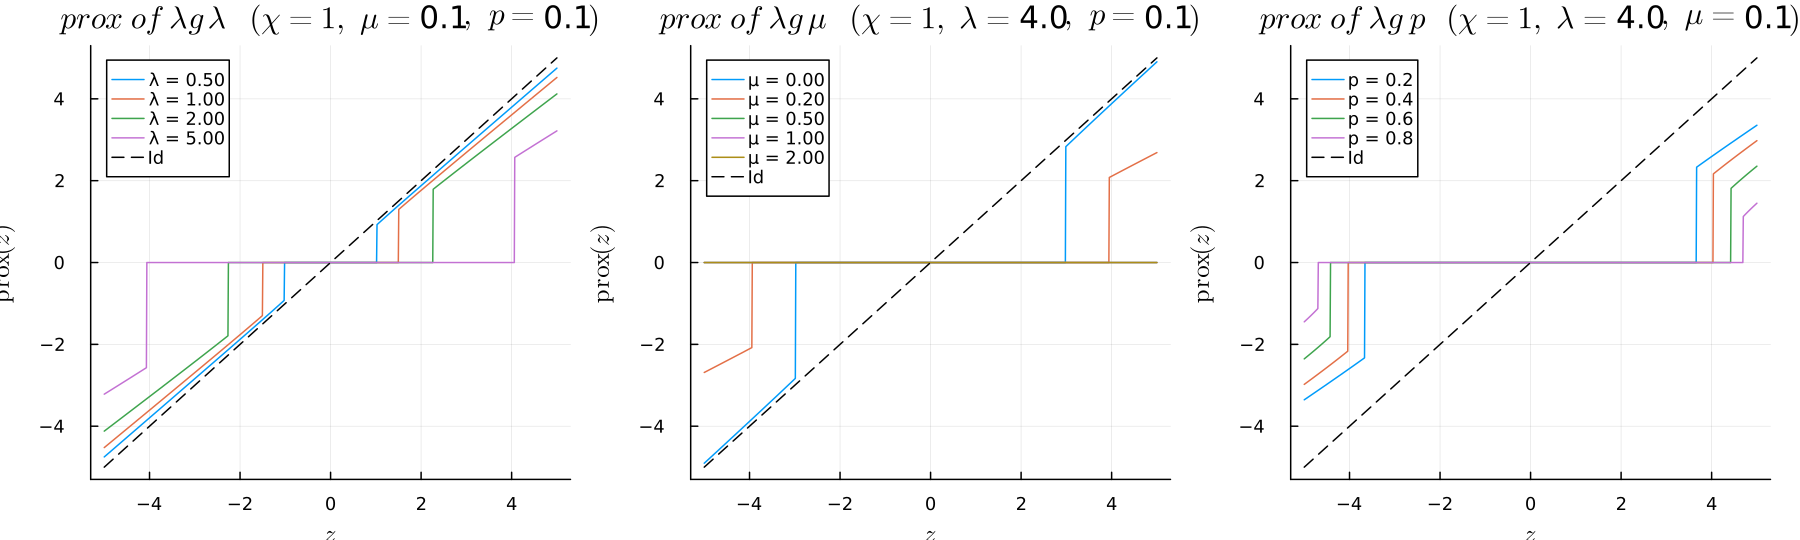

In [5]:
using Plots, LaTeXStrings, Measures, Printf
gr()

# =========================================================
#  ℓ_p + ℓ_2 :  ρ_{p+2}(t) = χ t^p + (μ/2) t^2
#  Prox of λ*g by bisection on the scalar equation:
#       G(u) = u + γλ( μ u + χ p u^(p-1) ) = v = |z|
#  Threshold φ = G(κ),  κ = [ 2 γ λ χ (1-p) / (1 + γ λ μ) ]^(1/(2-p))
#  Lower bracket  η = [ γ λ χ p (1-p) / (1 + γ λ μ) ]^(1/(2-p))
# =========================================================

G(u, γ, λ, χ, μ, p) = u + γ*λ*(μ*u + χ*p*u^(p-1))

function lp2_constants(γ, λ, χ, μ, p)
    @assert 0 < p < 1
    @assert γ > 0 && λ > 0 && χ > 0 && μ >= 0
    η = (γ*λ*χ*p*(1-p) / (1 + γ*λ*μ))^(1/(2 - p))
    κ = (2*γ*λ*χ*(1 - p) / (1 + γ*λ*μ))^(1/(2 - p))
    φ = G(κ, γ, λ, χ, μ, p)
    return η, κ, φ
end

# Scalar proximal of λ*g
function prox_lp2_scalar(z, γ, λ, χ, μ, p; tol=1e-12, maxit=200)
    η, κ, φ = lp2_constants(γ, λ, χ, μ, p)
    v = abs(z)
    s = sign(z)
    if v <= φ
        return 0.0
    end
    # Solve G(u)=v by bisection on [η, v] (G is strictly increasing there)
    lo = η
    hi = max(v, η)   # guard if v≈η
    # Numerical guard: ensure G(lo) ≤ v ≤ G(hi)
    if G(lo, γ, λ, χ, μ, p) > v
        lo *= 0.5
    end
    if G(hi, γ, λ, χ, μ, p) < v
        hi = max(2v, v + 1.0)
    end
    for _ in 1:maxit
        mid = 0.5*(lo + hi)
        gmid = G(mid, γ, λ, χ, μ, p)
        if abs(gmid - v) <= tol*(1 + v)
            return s*mid
        elseif gmid < v
            lo = mid
        else
            hi = mid
        end
    end
    return s*0.5*(lo + hi)
end

# Vectorized wrapper
prox_lp2(z, γ, λ, χ, μ, p; kwargs...) =
    broadcast(x -> prox_lp2_scalar(x, γ, λ, χ, μ, p; kwargs...), z)

# =========================================================
# Plot setup
# =========================================================

γ = 1.0               # step size (fixe pour les tracés)
χ = 1.0               # demandé: chi fixe (paramètre de la pénalité, pas la régularisation)
z_grid = range(-5, 5; length = 1000)

# --- 1) Variation de λ (χ, μ, p fixés) ---
λs   = [0.5, 1.0, 2.0, 5.0]
μ_fix = 0.1
p_fix = 0.1

pltλ = plot(
    title  = L"prox\ of\ \lambda g\: \lambda\quad (\chi=1,\ \mu="
             * "$(μ_fix)" * L",\ p=" * "$(p_fix)" * L")",
    xlabel = L"z", ylabel = L"\operatorname{prox}(z)",
    legend = :topleft, margin = 3mm, plot_margin = 0mm, dpi = 150, lw = 2,
)
for λ in λs
    plot!(pltλ, z_grid, z -> prox_lp2(z, γ, λ, χ, μ_fix, p_fix),
          label = @sprintf("λ = %.2f", λ))
end
plot!(pltλ, z_grid, z_grid; linestyle = :dash, color = :black, label = "Id")

# --- 2) Variation de μ (χ, λ, p fixés) ---
μs   = [0.0, 0.2, 0.5, 1.0, 2.0]
λ_fix = 4.0

pltμ = plot(
    title  = L"prox\ of\ \lambda g\: \mu\quad (\chi=1,\ \lambda="
             * "$(λ_fix)" * L",\ p=" * "$(p_fix)" * L")",
    xlabel = L"z", ylabel = L"\operatorname{prox}(z)",
    legend = :topleft, margin = 3mm, plot_margin = 0mm, dpi = 150, lw = 2,
)
for μ in μs
    plot!(pltμ, z_grid, z -> prox_lp2(z, γ, λ_fix, χ, μ, p_fix),
          label = @sprintf("μ = %.2f", μ))
end
plot!(pltμ, z_grid, z_grid; linestyle = :dash, color = :black, label = "Id")

# --- 3) Variation de p (χ, λ, μ fixés) ---
ps = [0.2, 0.4, 0.6, 0.8]

pltp = plot(
    title  = L"prox\ of\ \lambda g\: p\quad (\chi=1,\ \lambda="
             * "$(λ_fix)" * L",\ \mu=" * "$(μ_fix)" * L")",
    xlabel = L"z", ylabel = L"\operatorname{prox}(z)",
    legend = :topleft, margin = 3mm, plot_margin = 0mm, dpi = 150, lw = 2,
)
for p in ps
    plot!(pltp, z_grid, z -> prox_lp2(z, γ, λ_fix, χ, μ_fix, p),
          label = @sprintf("p = %.1f", p))
end
plot!(pltp, z_grid, z_grid; linestyle = :dash, color = :black, label = "Id")

# --- Composition finale ---
plot(pltλ, pltμ, pltp; layout = (1, 3), size = (1200, 360))


In [47]:
n, p = 70, 250
s_lst = 0:25
B_trial = 25
sigma = 0.1
α = 0.05 

χ = 1.
μ = 0.1
pow = 0.5
;

In [48]:
function run_trial_lpl2(X, β, σ, pow, χ, μ; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0.)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c
    
    λ = 1.


    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)

    rho_p2(χ, μ, pow, x) = χ*abs.(x).^pow + 0.5*μ*x.^2

    g(θ)  = λ * sum(rho_p2(χ, μ,pow, θ[1:end-1]))  # penalty
    prox( z,γ ) = prox_lp2(z, γ, λ, χ, μ, pow)
    θ_hat = ista(θ, f, g, ∇f, L0, prox;max_iter = 10_000,tol= tol,verbose  = false)
    return θ_hat[1:p]
end
   
function phase_transition_lpl2(n, p, s_list,pow, χ, μ ; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β_par = zeros(p)
            β_par[randperm(p)[1:s]] .= 3
            β_par_hat = run_trial_lpl2(X, β_par, σ,pow, χ, μ; α=α, tol=tol, c=0)

            y, ŷ = abs.(β_par) .> 0, abs.(β_par_hat) .> 0

            acc_pesr += pesr(β_par, β_par_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_lpl2 (generic function with 1 method)

In [49]:
s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_lpl2(n, p, s_lst, pow, χ, μ; σ=sigma, B=B_trial, tol=1e-9)

(0:25, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.68, 0.44, 0.32, 0.2, 0.08, 0.2, 0.08, 0.0, 0.04, 0.0], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.833984200745694, 0.7419543436292324, 0.7295453710690444, 0.6443843579145978, 0.6251307996301437, 0.5993628434071665, 0.5860027546996553, 0.5694770367989702, 0.5517277091993137, 0.5504141015783729], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.19156926075873443, 0.31459087116484225, 0.3310426444304961, 0.4337882684649226, 0.4569838239792927, 0.45388328320630866, 0.4830061099130948, 0.5040341347046019, 0.5082195649287352, 0.5112545486371829], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.875, 0.8352941176470591, 0.8222222222222222, 0.7684210526315788, 0.748, 0.6761904761904762, 0.6854545454545453, 0.6713043478260868, 0.6333333333333333, 0.6336])

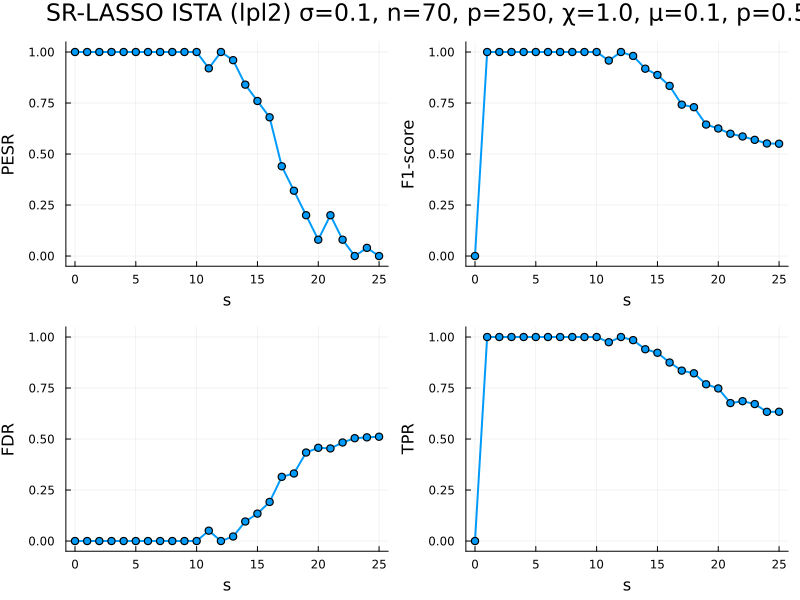

In [50]:
main_title = "SR-LASSO ISTA (lpl2) σ=$sigma, n=$n, p=$p, χ=$χ, μ=$μ, p=$pow"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

Result are interesting and similar to $P_\nu$. Drawbacks and benefits : find good $\chi, \mu$ and the good power of $p$.

**$\Lambda$** is degenerated (constant to $0$) so we **can't** use $QUT$ methodology. Nonetheless we can still try some things

+ Modifiy $|x|^p$ in $(|x|+\varepsilon)^p-\varepsilon^p$ for some small $\varepsilon>0$
+ Find $\lambda_0$ and not $\lambda_0^{local}$

# $|x|^p$ in $(|x|+\varepsilon)^p-\varepsilon^p$

For $0<p<1$, $\chi>0$, $\varepsilon>0$ (and optionally $\mu\ge 0$) and $\psi(x)=\rho_{p,\varepsilon}(|x|)$,

$$
\rho_{p,\varepsilon}(t)
=\chi\bigl( (t+\varepsilon)^p-\varepsilon^p \bigr)
\;+\;\frac{\mu}{2}\,t^2,\qquad t\ge 0
$$



$$
\rho_{p,\varepsilon}'(0^+)=\chi\,p\,\varepsilon^{\,p-1}\,
$$

Denote $\alpha_\varepsilon:=\chi p\,\varepsilon^{p-1}$


$$ \Lambda=\frac{\|\nabla f(0)\|_\infty}{\alpha_\varepsilon}
=\frac{\|\nabla f(0)\|_\infty}{\chi p\,\varepsilon^{p-1}}
$$



Work scalar with $z\in\mathbb R$, $v=|z|$, $s=\operatorname{sign}(z)$, step $\gamma>0$.
Define

$$
H(u)\;=\;u\;+\;\gamma\lambda\bigl(\mu u+\chi p\,(u+\varepsilon)^{p-1}\bigr),
\qquad u\ge 0.
$$

**Threshold at zero (soft-like):**

$$
t_0=\gamma\,\lambda\,\alpha_\varepsilon
=\gamma\,\lambda\,\chi p\,\varepsilon^{p-1}.
$$

Then

$$
\operatorname{prox}_{\gamma,\lambda\psi}(z)=
\begin{cases}
0 & \text{if } v\le t_0,\\[4pt]
s\,u^\star & \text{if } v>t_0,\ \text{where }u^\star\text{ solves }H(u)=v.
\end{cases}
$$

In [76]:
# ρ_{p,ε}(t) = χ((t+ε)^p - ε^p) + (μ/2)t^2
rho_peps(t, χ, μ, p, ε) = χ*((t+ε)^p - ε^p) + 0.5*μ*t^2

# H(u) = u + γλ( μ u + χ p (u+ε)^(p-1) )
H(u, γ, λ, χ, μ, p, ε) = u + γ*λ*(μ*u + χ*p*(u + ε)^(p-1))

# Cost for comparison: m(u; v) = λρ(u) + (u - v)^2/(2γ), for u≥0 and v=|z|
function m_cost(u, v, γ, λ, χ, μ, p, ε)
    return λ*rho_peps(u, χ, μ, p, ε) + (u - v)^2/(2γ)
end

"""
    prox_bridge_eps(z, γ, λ, χ, μ, p, ε; tol=1e-12, maxit=200)

Prox of λ * ψ where ψ(x) = χ((|x|+ε)^p - ε^p) + (μ/2)|x|^2,  0<p<1, ε>0, μ≥0.

- Soft-like threshold t0 = γ λ χ p ε^(p-1).
- If H'≥0 on [0,∞), unique root and φ = t0.
- Otherwise solve on the right branch and compare cost with 0 when needed.
"""
function prox_bridge_eps_scalar(z, γ, λ, χ, μ, p, ε; tol=1e-12, maxit=200)
    @assert 0 < p < 1 && ε > 0 && γ > 0 && λ > 0 && χ > 0 && μ ≥ 0
    v = abs(z); s = sign(z)
    αε = χ*p*ε^(p-1)
    t0 = γ*λ*αε
    if v ≤ t0
        return 0.0
    end
    # Monotonicity check at 0 (worst case for H')
    d0 = 1 + γ*λ*μ - γ*λ*χ*p*(1-p)*ε^(p-2)
    if d0 > 0
        # strictly increasing: single root in [0, v]
        lo, hi = 0.0, max(v, 1e-12)
        for _ in 1:maxit
            mid = 0.5*(lo + hi)
            gmid = H(mid, γ, λ, χ, μ, p, ε)
            if abs(gmid - v) ≤ tol*(1 + v)
                return s*mid
            elseif gmid < v
                lo = mid
            else
                hi = mid
            end
        end
        return s*0.5*(lo + hi)
    else
        # unimodal: compute the turning point
        uturn_plus = (γ*λ*χ*p*(1-p) / (1 + γ*λ*μ))^(1/(2 - p))
        uturn = max(0.0, uturn_plus - ε)
        vmin = H(uturn, γ, λ, χ, μ, p, ε)
        if v ≤ vmin
            return 0.0
        end
        # right-branch bisection on [uturn, max(v, uturn+1)]
        lo, hi = uturn, max(v, uturn + 1.0)
        for _ in 1:maxit
            mid = 0.5*(lo + hi)
            gmid = H(mid, γ, λ, χ, μ, p, ε)
            if abs(gmid - v) ≤ tol*(1 + v)
                u = mid
                # optional: compare cost with 0 for safety
                if m_cost(u, v, γ, λ, χ, μ, p, ε) ≤ m_cost(0.0, v, γ, λ, χ, μ, p, ε)
                    return s*u
                else
                    return 0.0
                end
            elseif gmid < v
                lo = mid
            else
                hi = mid
            end
        end
        u = 0.5*(lo + hi)
        if m_cost(u, v, γ, λ, χ, μ, p, ε) ≤ m_cost(0.0, v, γ, λ, χ, μ, p, ε)
            return s*u
        else
            return 0.0
        end
    end
end

# Vectorized wrapper
prox_bridge_eps(Z, γ, λ, χ, μ, p, ε; kwargs...) =
    broadcast(z -> prox_bridge_eps_scalar(z, γ, λ, χ, μ, p, ε; kwargs...), Z)

prox_bridge_eps (generic function with 1 method)

In [77]:
function lambda_local0(y, X, a; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / (a*norm(r))
end

function lambda_qut_lpl2_eps(X, pow, χ, ε; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    a = χ*pow*ε^(pow-1)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X, a; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_lpl2_eps (generic function with 1 method)

In [119]:
function run_trial_lpl2_eps(X, β, σ, pow, χ, μ, ε; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0.)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c
    
    λ = lambda_qut_lpl2_eps(X, pow, χ, ε; α=α, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)

    rho_p2_eps(χ, μ, pow, ε, x) = χ*((abs.(x).+ε).^pow .- ε^pow) .+ 0.5*μ*x.^2

    g(θ)  = λ * sum(rho_p2_eps(χ, μ,pow, ε, θ[1:end-1]))  # penalty
    prox(z, γ) = prox_bridge_eps(z, γ, λ, χ, μ, pow, ε)
    θ_hat = ista(θ, f, g, ∇f, L0, prox; max_iter = 10_000,tol= tol,verbose  = false)
    return θ_hat[1:p]
end
   
function phase_transition_lpl2_eps(n, p, s_list,pow, χ, μ, ε ; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β_par = zeros(p)
            β_par[randperm(p)[1:s]] .= 3
            β_par_hat = run_trial_lpl2_eps(X, β_par, σ,pow, χ, μ, ε; α=α, tol=tol, c=0)

            y, ŷ = abs.(β_par) .> 0, abs.(β_par_hat) .> 0

            acc_pesr += pesr(β_par, β_par_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_lpl2_eps (generic function with 1 method)

In [132]:
n, p = 70, 250
s_lst = 0:20
B_trial = 15
sigma = 0.1
α = 0.05 

χ = 1.
μ = 0.1
pow = 0.5
ε = 0.001
;

In [133]:
s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_lpl2_eps(n, p, s_lst, pow, χ, μ, ε; σ=sigma, B=B_trial, tol=1e-9)

(0:20, [1.0, 0.9333333333333333, 1.0, 0.9333333333333333, 0.8666666666666667, 0.8666666666666667, 0.8, 0.8666666666666667, 0.8666666666666667, 0.3333333333333333  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.9777777777777777, 1.0, 0.9833333333333333, 0.9851851851851853, 0.9878787878787879, 0.9846153846153847, 0.8833333333333333, 0.8909090909090909, 0.5680840796630271  …  0.25733821733821727, 0.22447329359094065, 0.24875350140056016, 0.14995642701525055, 0.13959694989106752, 0.1257516339869281, 0.1277738791423002, 0.08771929824561404, 0.052063492063492055, 0.0860781730346948], [0.0, 0.03333333333333333, 0.0, 0.02666666666666667, 0.02666666666666667, 0.02222222222222222, 0.02857142857142857, 0.0, 0.02222222222222222, 0.04555555555555556  …  0.0, 0.027777777777777776, 0.013333333333333334, 0.10555555555555556, 0.1111111111111111, 0.03333333333333333, 0.0, 0.0, 0.06666666666666667, 0.13333333333333333], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8761904761904762, 0.883333333333

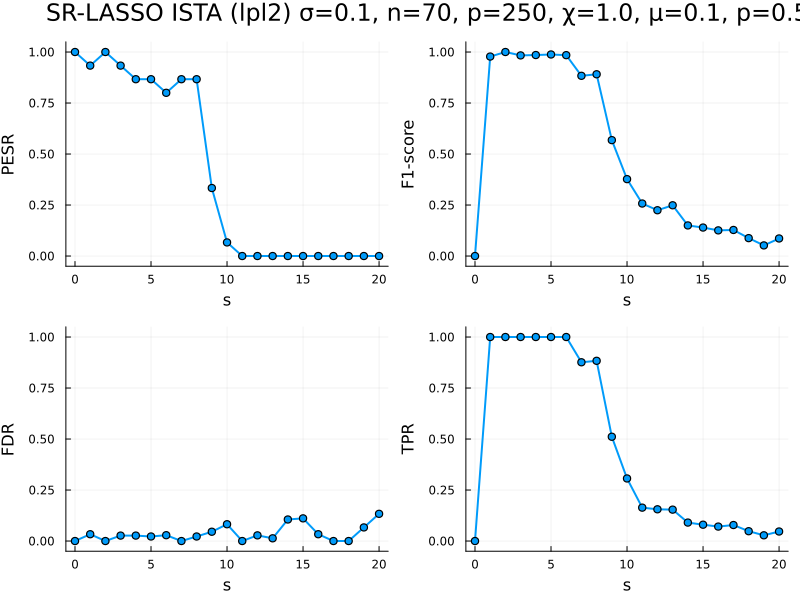

In [134]:
main_title = "SR-LASSO ISTA (lpl2) σ=$sigma, n=$n, p=$p, χ=$χ, μ=$μ, p=$pow"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

Results aren't encouraging...